# prior_predictive

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns

from scipy import constants
import astropy.constants

import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-03-25 17:34:23.736513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 17:34:23.736546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 17:34:23.737596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 17:34:23.743005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 17:34:24.263653: W tensorflow/compiler/tf2

In [ ]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [3]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
4620661,1.04,0.019517,0.3,2.1,4.2501,1.107636,1.337639,5902.221729,0.017603,599.860616,...,0.4197,0.42063,0.420058,0.420794,0.421165,0.420697,0.419119,0.416632,0.414054,0.412505


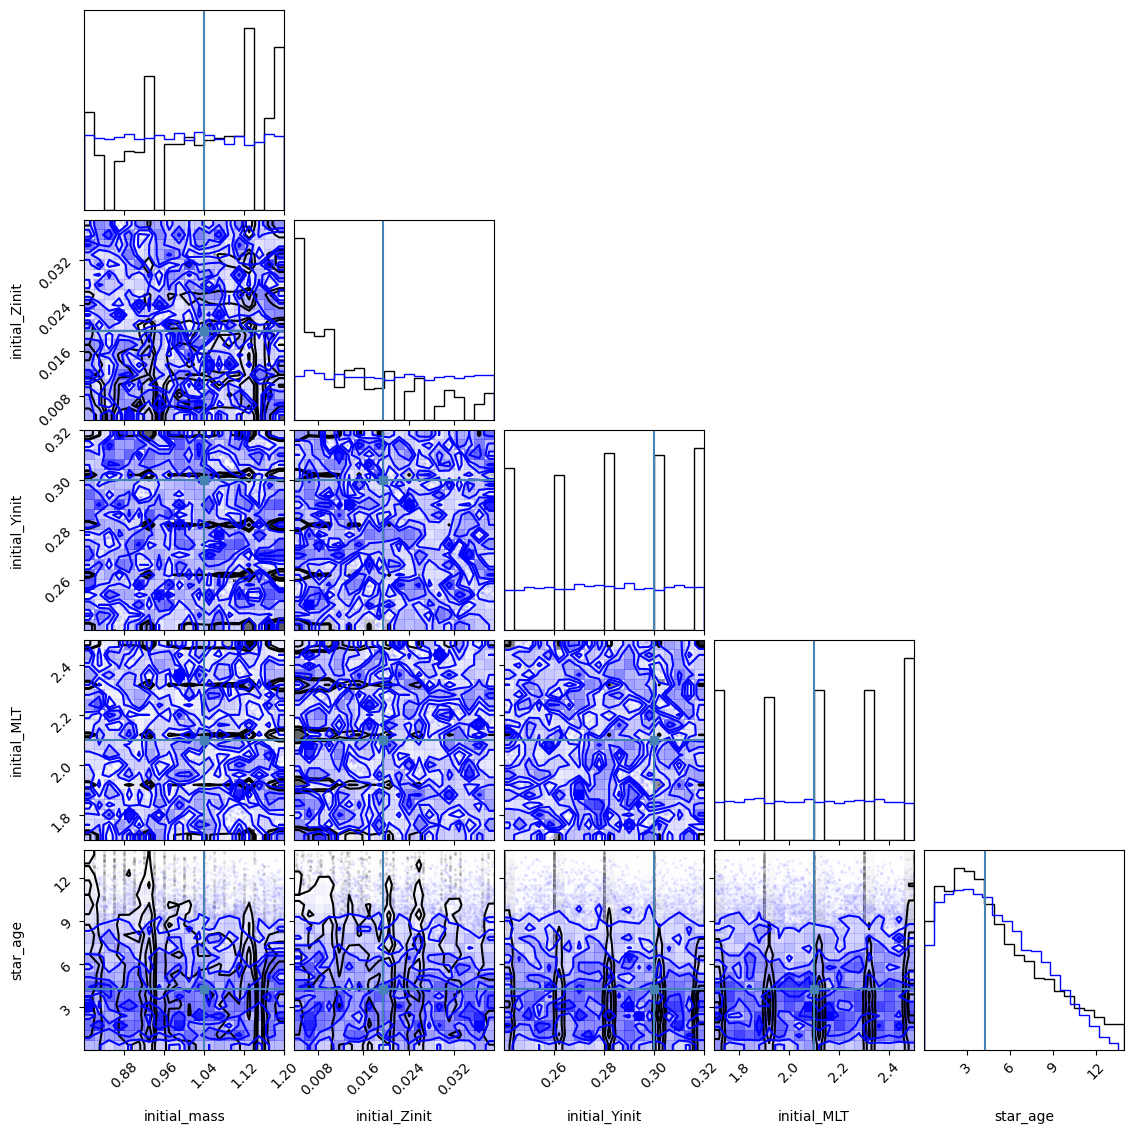

In [4]:
"""
Define priors
"""

def uniform_prior(model_inps, header):
    model_min = model_inps[header].min()
    return scipy.stats.uniform(loc=model_min, scale=model_inps[header].max()-model_min)

def normal_prior(model_inps, header, scale):
    return scipy.stats.norm(loc=model_inps[header], scale=scale)

# mass_prior = normal_prior(model_inps, "initial_mass",.01)

# Zinit_prior = normal_prior(model_inps,"initial_Zinit",.001)

# Yinit_prior = normal_prior(model_inps, "initial_Yinit",.005)

# MLT_prior = normal_prior(model_inps, "initial_MLT",.05)

# age_prior = normal_prior(model_inps, "star_age",1)

mass_prior = uniform_prior(df, "initial_mass")

Zinit_prior = uniform_prior(df,"initial_Zinit")

Yinit_prior = uniform_prior(df, "initial_Yinit")

MLT_prior = uniform_prior(df, "initial_MLT")

age_prior = scipy.stats.beta(a=1.3, b=2.4, loc=df['star_age'].min(), scale=df['star_age'].max())


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000));

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);

In [5]:
pitchfork = emulator("nu6-40_elu")

2024-03-25 15:57:37.478188: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-25 15:57:37.478211: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-03-25 15:57:37.478216: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-03-25 15:57:37.478314: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-03-25 15:57:37.478333: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-03-25 15:57:37.478337: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


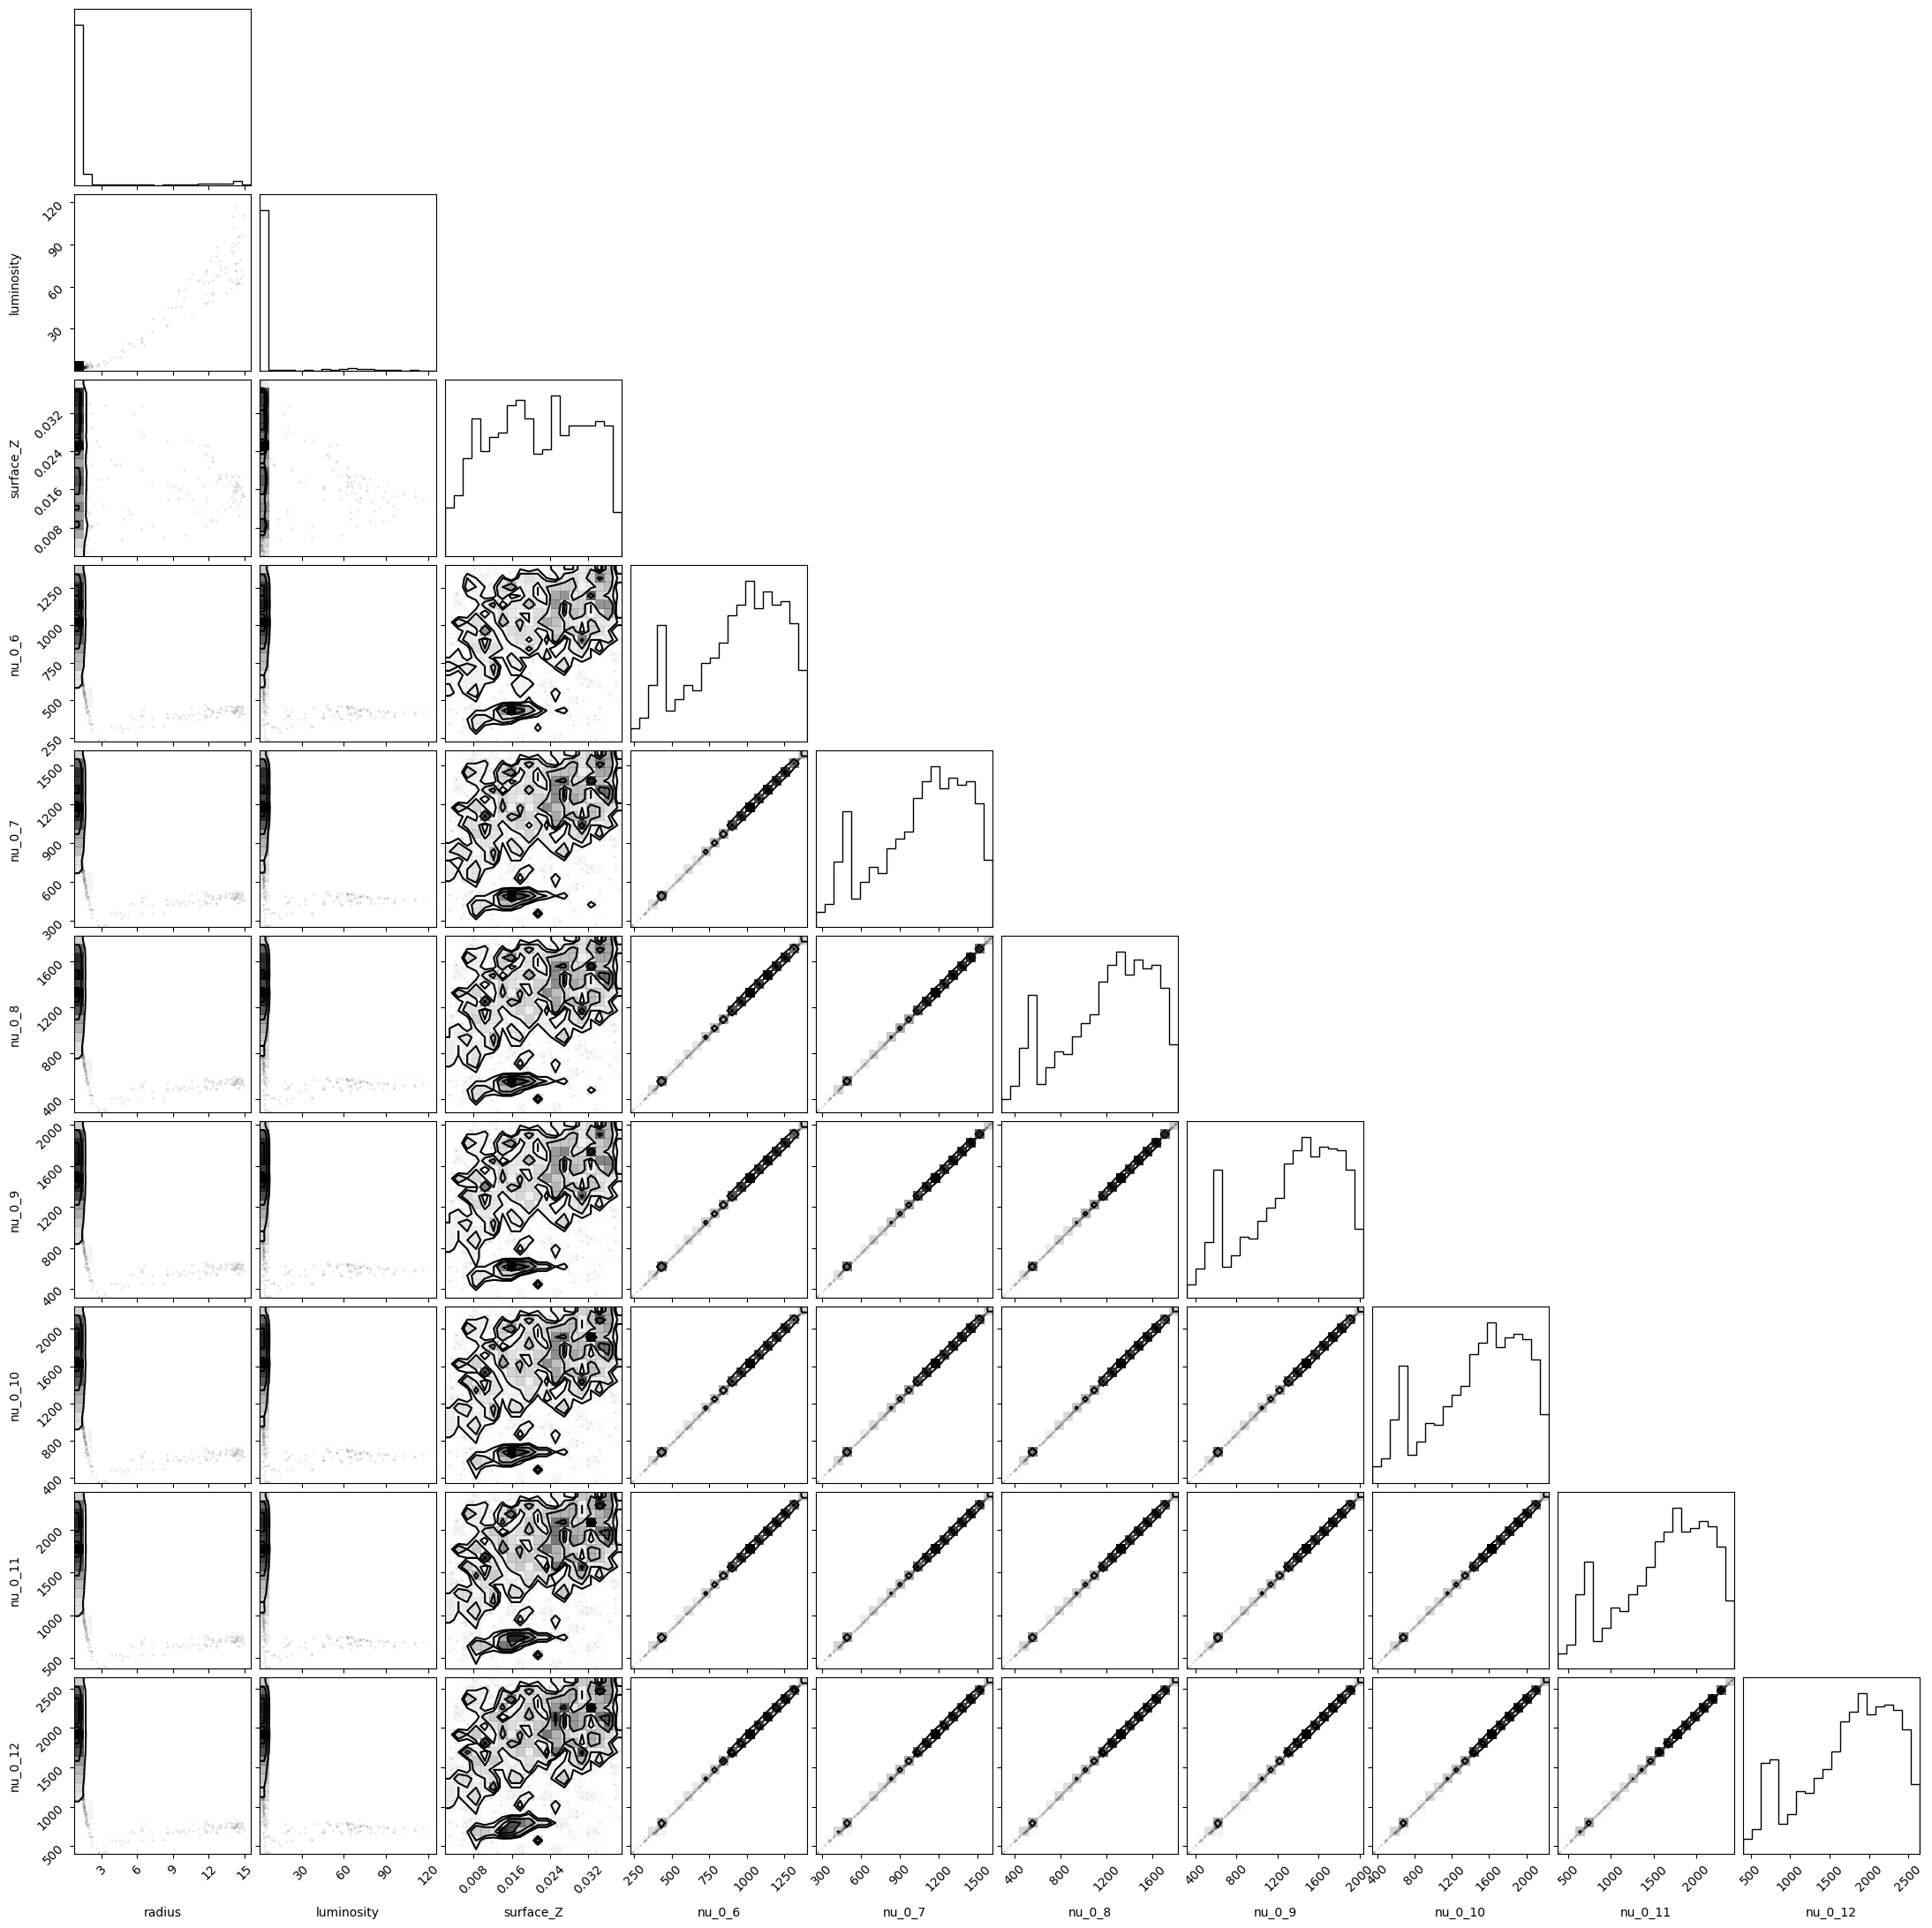

In [6]:
size = 1000
prior_samples = np.array([mass_prior.rvs(size=size),Zinit_prior.rvs(size=size), Yinit_prior.rvs(size=size), MLT_prior.rvs(size=size), age_prior.rvs(size=size)]).T

prior_predictives = pitchfork.predict(prior_samples)
corner.corner(prior_predictives[:,:10], labels = outputs[:10]);

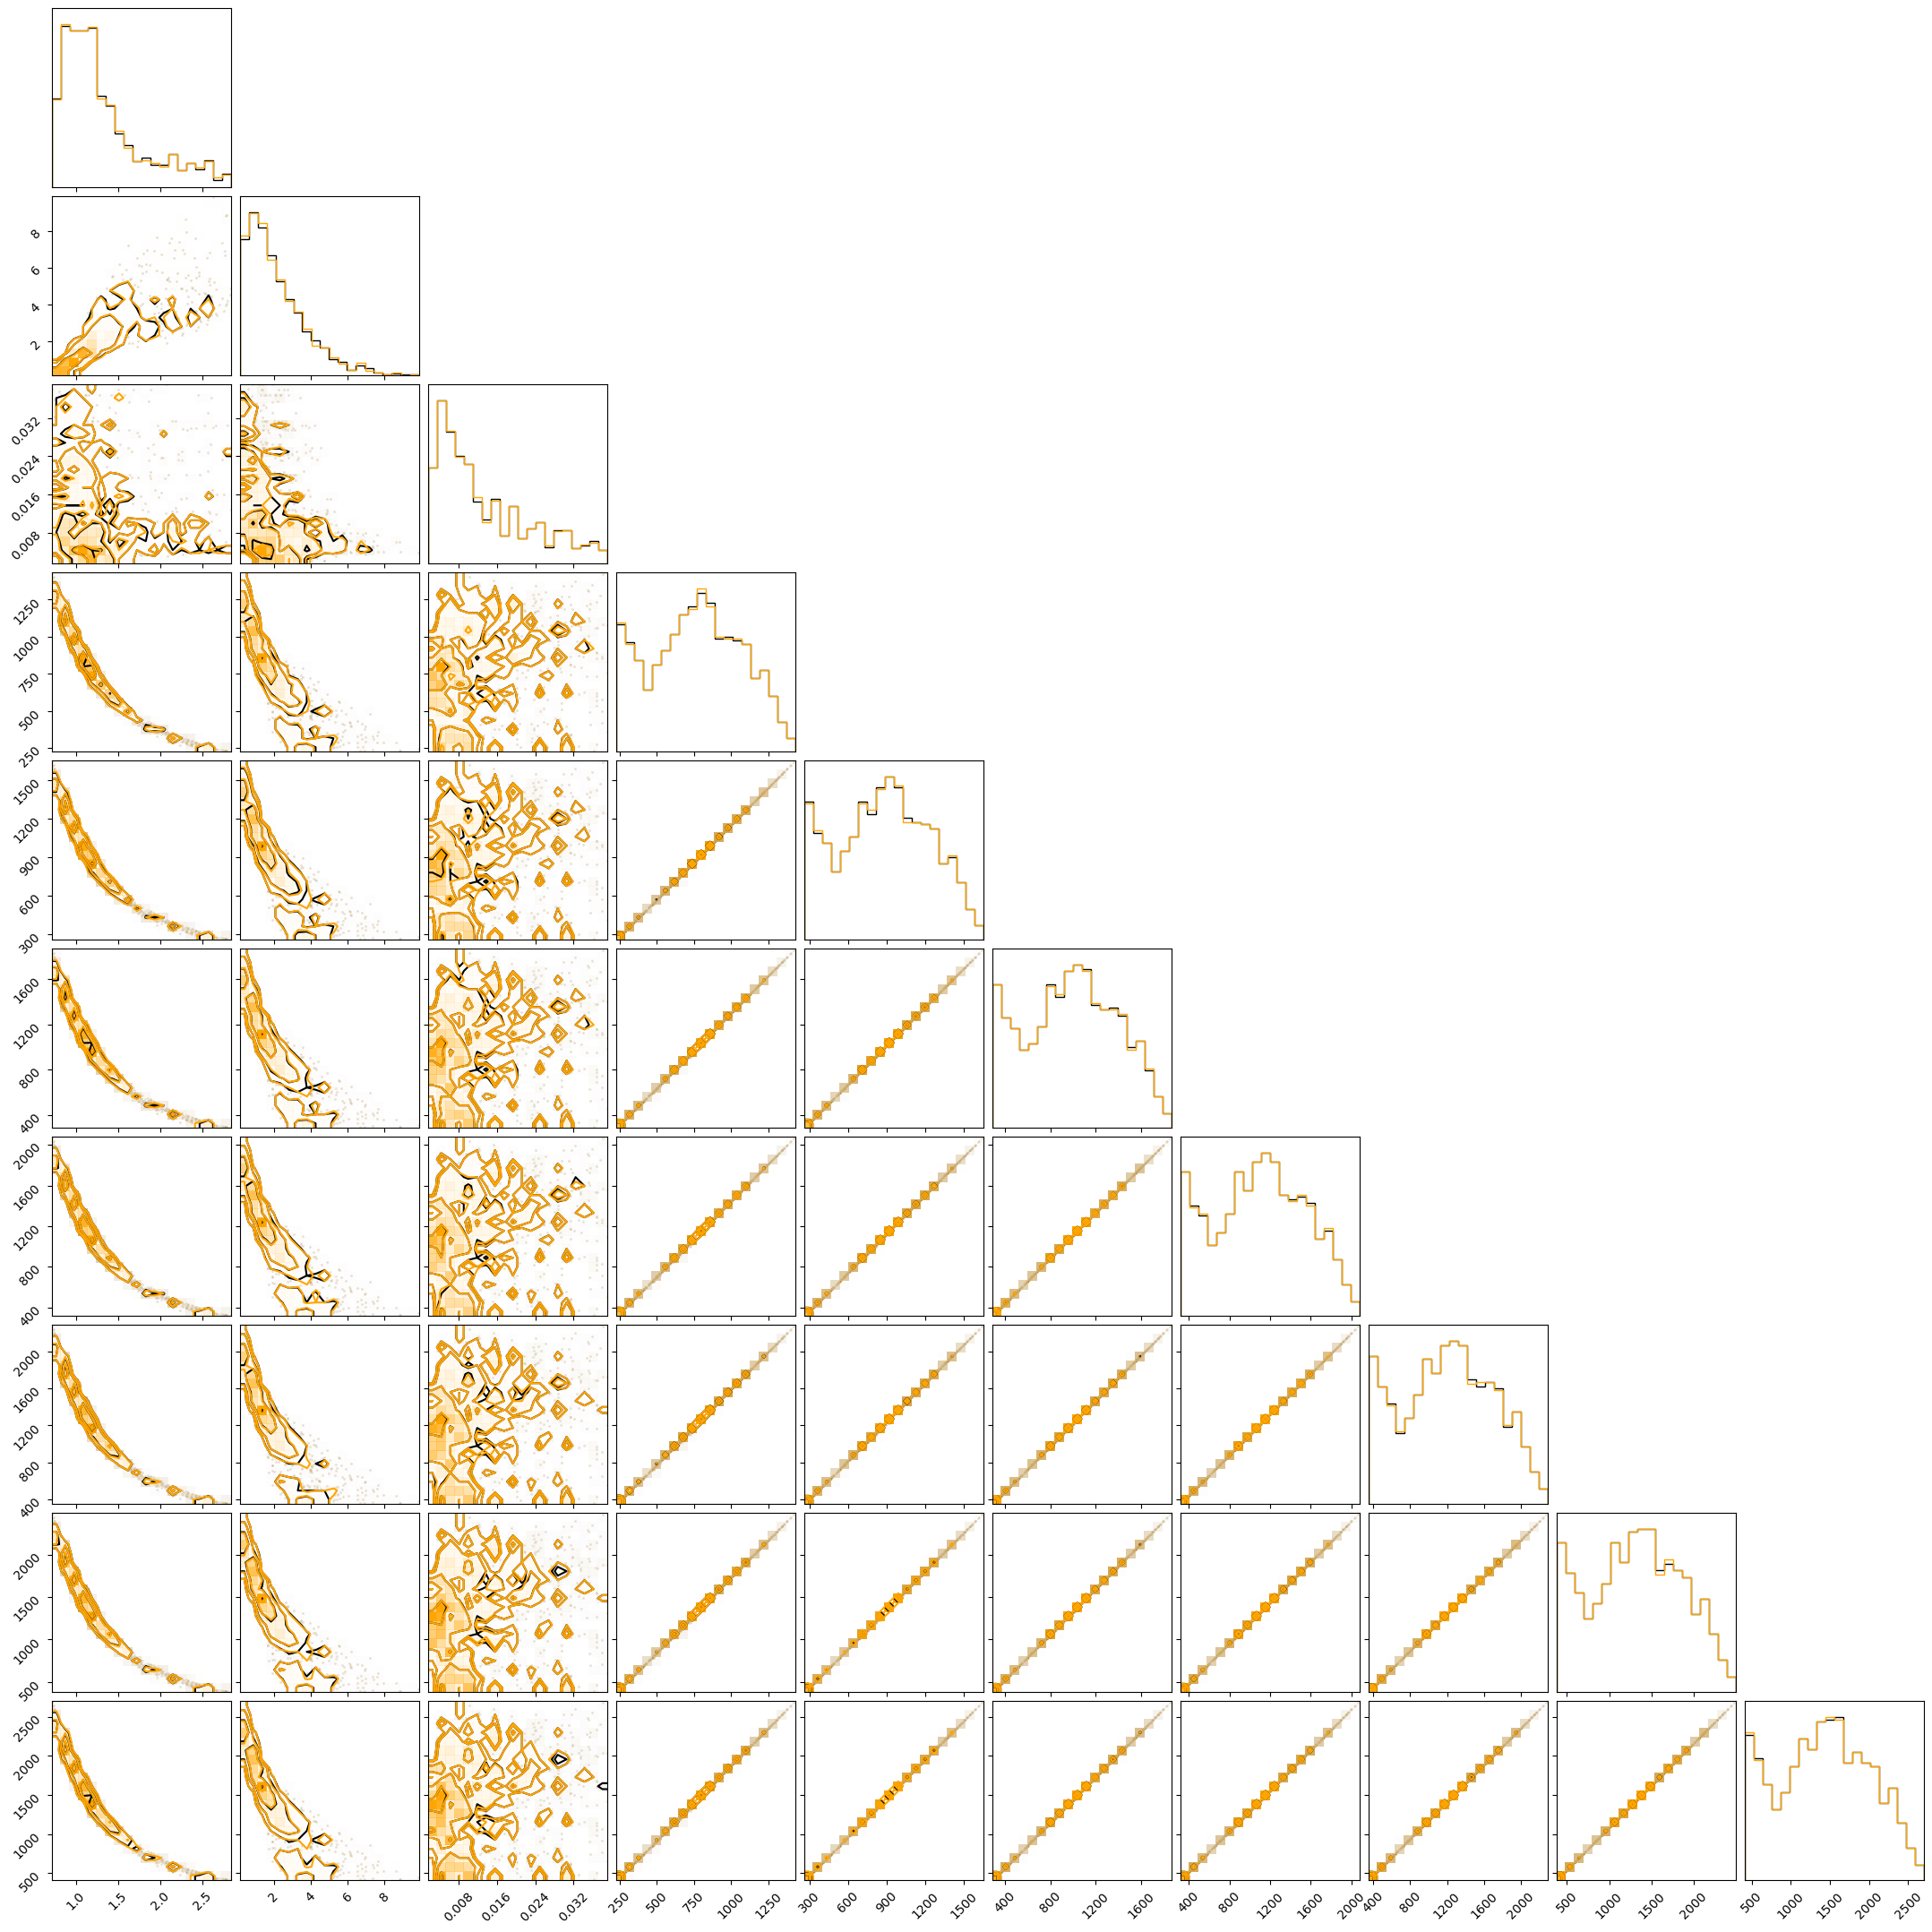

In [233]:
df_sample = df.sample(n=1000)
figure = corner.corner(df_sample[outputs[:10]])
corner.corner(pitchfork.predict(df_sample[inputs].values)[:,:10], color='orange', fig=figure);

In [251]:
print(df['initial_Yinit'].unique())
print(df['initial_MLT'].unique())

[0.24 0.26 0.32 0.3  0.28]
[1.9 1.7 2.1 2.5 2.3]


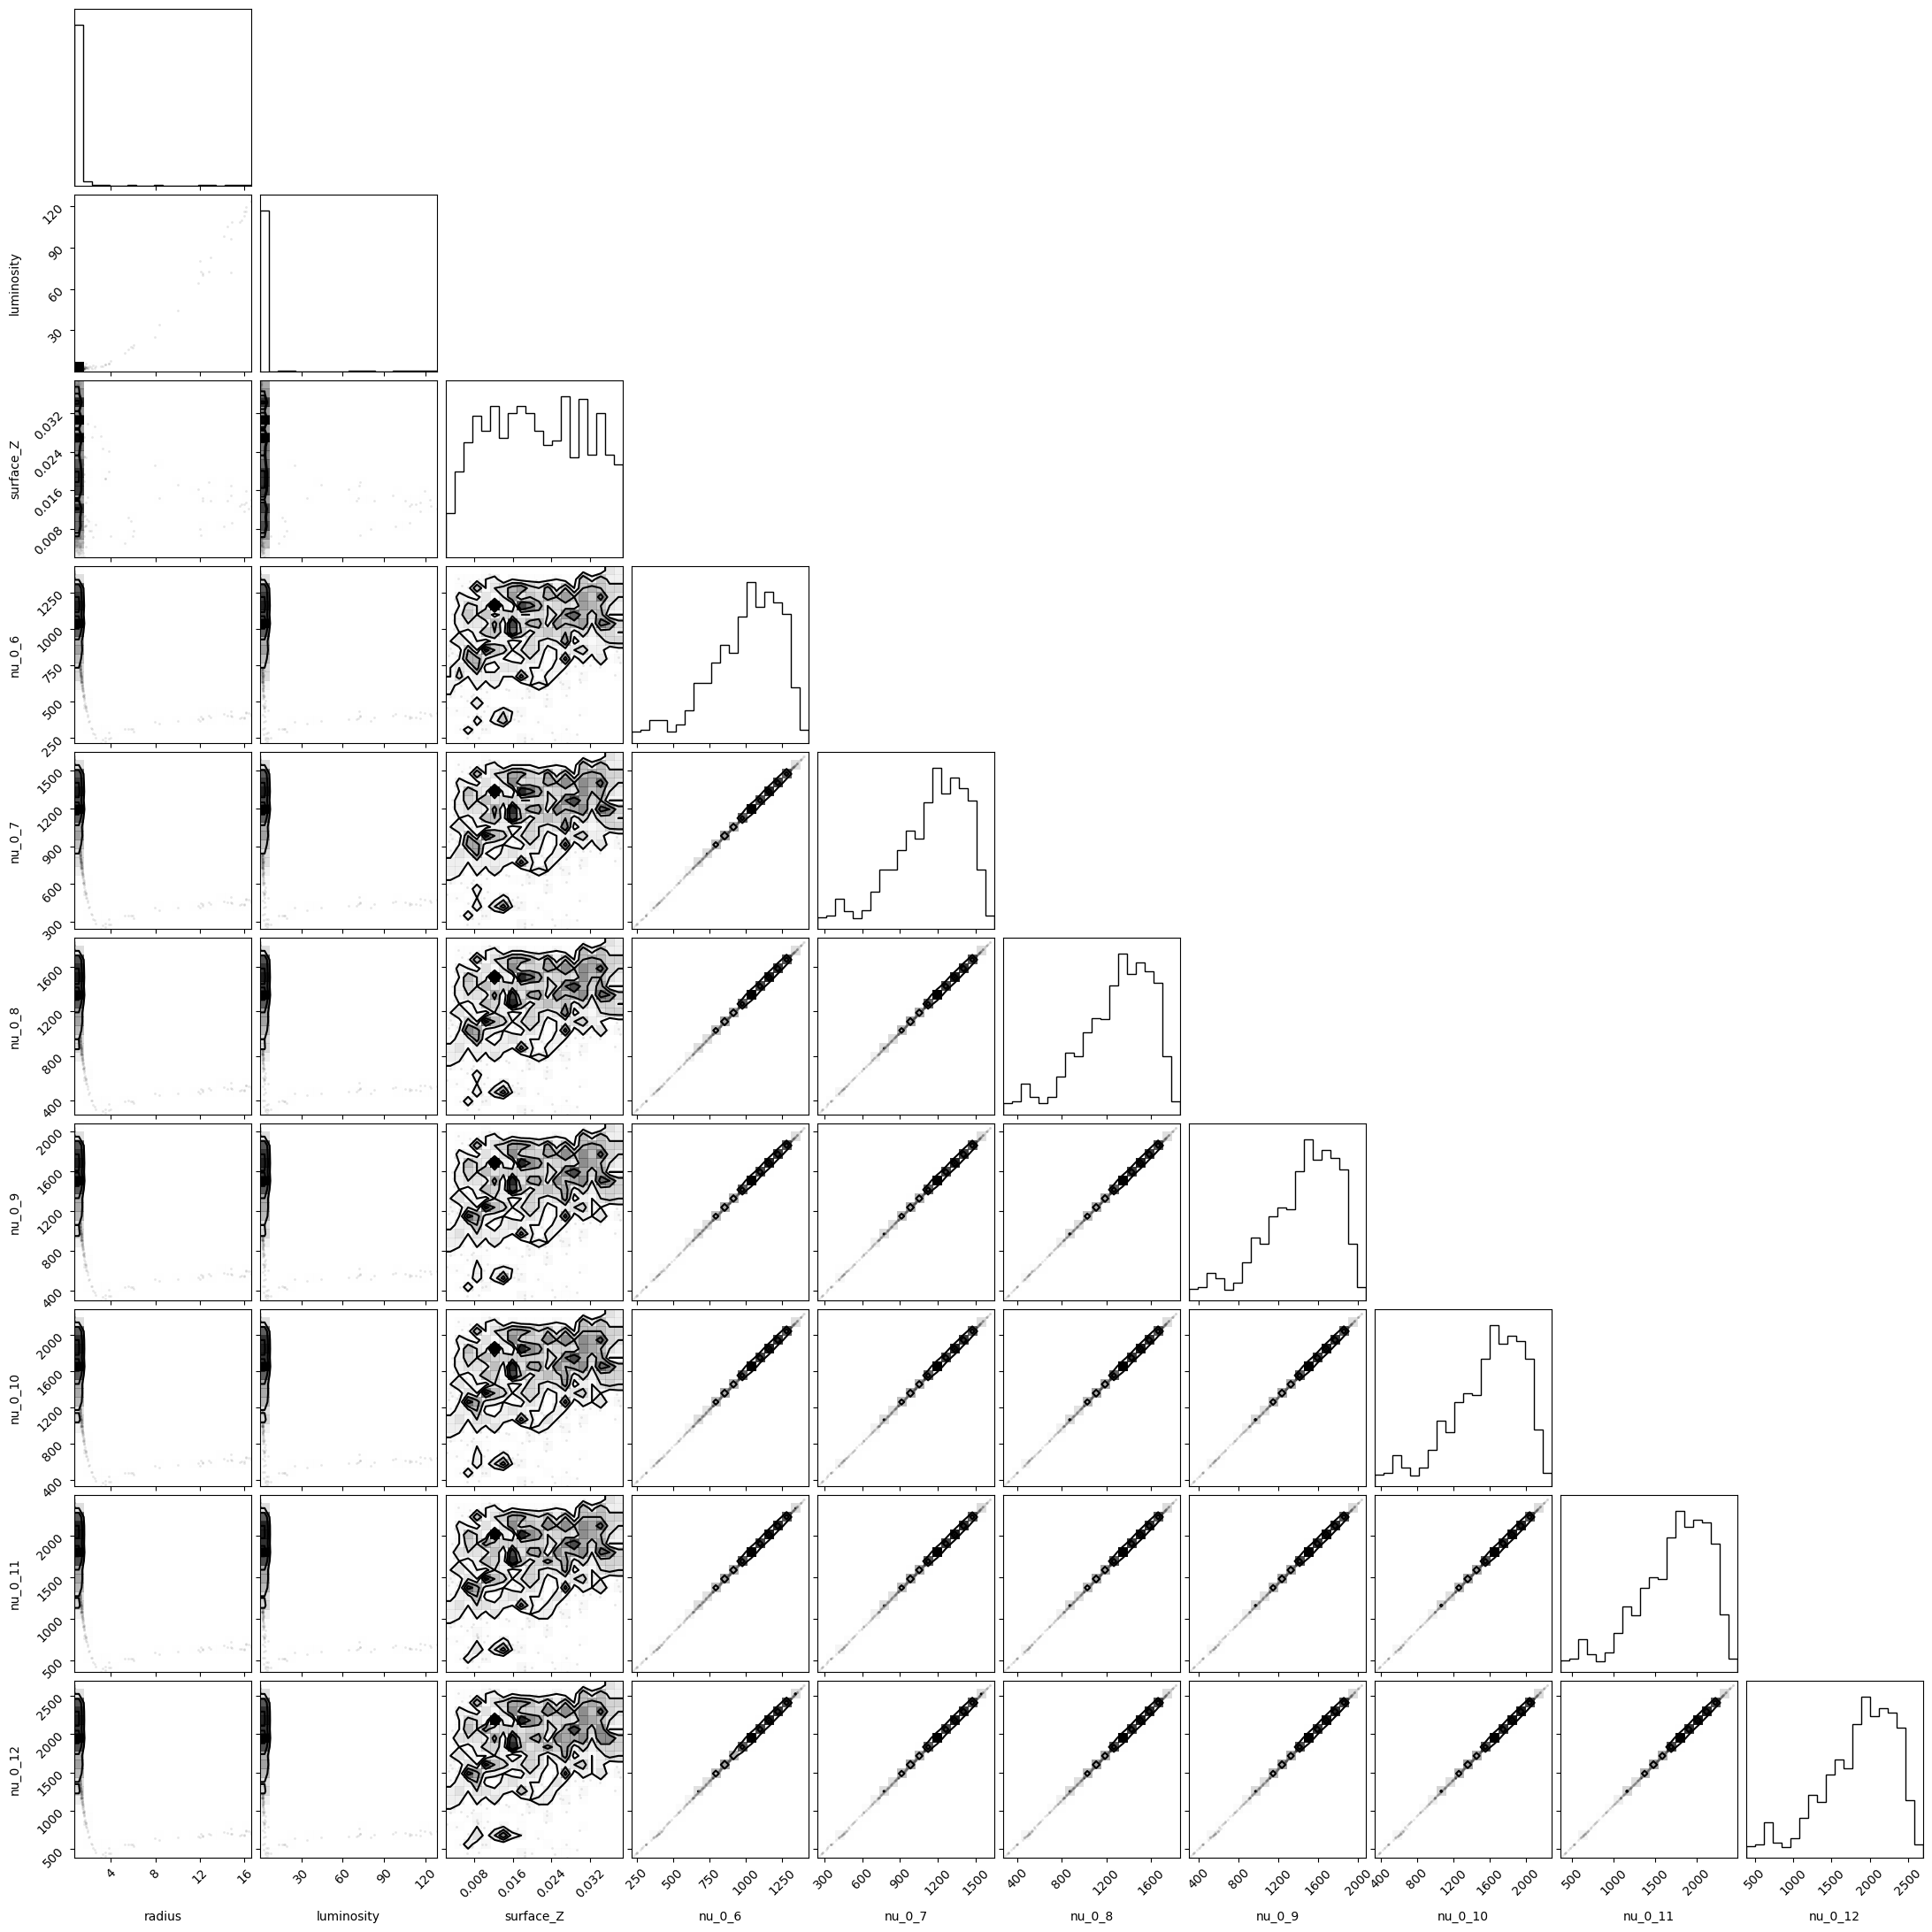

In [257]:
size = 1000
prior_samples = np.array([mass_prior.rvs(size=size),Zinit_prior.rvs(size=size), np.full(size, 0.24), np.full(size, 1.7), age_prior.rvs(size=size)]).T

prior_predictives = pitchfork.predict(prior_samples)
corner.corner(prior_predictives[:,:10], labels = outputs[:10]);

In [68]:
import matplotlib
%matplotlib qt
import matplotlib.pyplot as plt
print(matplotlib.get_backend())

from matplotlib.widgets import Button, Slider

# The parametrized function to be plotted
def calc_Teff(luminosity, radius):
    return np.array(((luminosity*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius*astropy.constants.R_sun)**2)))**0.25)

def f(pitchfork, Mass, Zinit, Yinit, MLT, age):
    Mass_array = np.full(len(age), Mass)
    Zinit_array = np.full(len(age), Zinit)
    Yinit_array = np.full(len(age), Yinit)
    MLT_array = np.full(len(age), MLT)

    preds = pitchfork.predict(np.array([Mass_array,Zinit_array, Yinit_array, MLT_array, age]).T)[:,:2]

    luminosity = preds[:,1]
    radius = preds[:,0]
    teff = calc_Teff(luminosity, radius)

    return teff, luminosity

age = np.linspace(df['star_age'].min(), df['star_age'].max(), 1000)

# Define initial parameters
init_Mass = 1
init_Zinit = 0.014
init_Yinit = 0.28
init_MLT = 2.1

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
teff, luminosity = f(pitchfork, init_Mass, init_Zinit, init_Yinit, init_MLT, age)
line, = ax.plot(np.log10(teff), np.log10(luminosity), lw=2)
ax.set_xlabel('teff')
ax.set_ylabel('L')
ax.invert_xaxis()

# adjust the main plot to make room for the sliders
fig.subplots_adjust( left=0.25,bottom=0.35,top=1)

# Make a horizontal slider to control the frequency.
axmass = fig.add_axes([0.25, 0.25, 0.65, 0.03])
mass_slider = Slider(
    ax=axmass,
    label='mass',
    valmin=df['initial_mass'].min(),
    valmax=df['initial_mass'].max(),
    valinit=init_Mass,
)

# Make a horizontal slider to control the frequency.
axzinit = fig.add_axes([0.25, 0.2, 0.65, 0.03])
zinit_slider = Slider(
    ax=axzinit,
    label='zinit',
    valmin=df['initial_Zinit'].min(),
    valmax=df['initial_Zinit'].max(),
    valinit=init_Zinit,
)

# Make a horizontal slider to control the frequency.
axyinit = fig.add_axes([0.25, 0.15, 0.65, 0.03])
yinit_slider = Slider(
    ax=axyinit,
    label='yinit',
    valmin=df['initial_Yinit'].min(),
    valmax=df['initial_Yinit'].max(),
    valinit=init_Yinit,
)

# Make a horizontal slider to control the frequency.
axmlt = fig.add_axes([0.25, 0.1, 0.65, 0.03])
mlt_slider = Slider(
    ax=axmlt,
    label='mlt',
    valmin=df['initial_MLT'].min(),
    valmax=df['initial_MLT'].max(),
    valinit=init_MLT,
)

# The function to be called anytime a slider's value changes
def update(val):
    teff, luminosity = f(pitchfork, mass_slider.val, zinit_slider.val, yinit_slider.val, mlt_slider.val, age)
    line.set_xdata(np.log10(teff))
    line.set_ydata(np.log10(luminosity))
    ax.set_xlim(np.log10(teff.max()*1.01),np.log10(teff.min()*0.99))
    ax.set_ylim(np.log10(luminosity.min()*0.9),np.log10(luminosity.max()*1.1))
    fig.canvas.draw_idle()


# register the update function with each slider
mass_slider.on_changed(update)
zinit_slider.on_changed(update)
yinit_slider.on_changed(update)
mlt_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    mass_slider.reset()
button.on_clicked(reset)

plt.show()

QtAgg


In [12]:
def f(pitchfork, Mass, Zinit, Yinit, MLT, age):
    Mass_array = np.full(len(age), Mass)
    Zinit_array = np.full(len(age), Zinit)
    Yinit_array = np.full(len(age), Yinit)
    MLT_array = np.full(len(age), MLT)

    
    return pitchfork.predict(np.array([Mass_array,Zinit_array, Yinit_array, MLT_array, age]).T)[:,:2]

array([[0.90381032, 0.70014199],
       [0.90389143, 0.70032209],
       [0.90397247, 0.7005019 ],
       ...,
       [1.00620743, 0.92559991],
       [1.00633857, 0.92588971],
       [1.00646927, 0.92617829]])

In [114]:
figure = corner.corner(np.array((df['initial_mass'].values,df['star_age'].values)).T,hist_kwargs={'density':True}, labels=['initial_mass','star_age'])

masses = df['initial_mass'].unique()
color = iter(cm.rainbow(np.linspace(0, 1, len(masses))))
for i in range(len(masses)-1):
    mass_df = df[(df['initial_mass']>=masses[i])&(df['initial_mass']<=masses[i+1])]
    c = next(color)
    corner.corner(np.array((mass_df['initial_mass'].values,mass_df['star_age'].values)).T,hist_kwargs={'density':True}, fig=figure,color=c)


In [115]:
figure = corner.corner(np.array((df['initial_Zinit'].values,df['star_age'].values)).T,hist_kwargs={'density':True}, labels=['initial_Zinit','star_age'])

zinits = np.linspace(df['initial_Zinit'].min(), df['initial_Zinit'].max(),10)
color = iter(cm.rainbow(np.linspace(0, 1, len(zinits))))
for i in range(len(zinits)-1):
    zinit_df = df[(df['initial_Zinit']>=zinits[i])&(df['initial_Zinit']<=zinits[i+1])]
    c = next(color)
    corner.corner(np.array((zinit_df['initial_Zinit'].values,zinit_df['star_age'].values)).T,hist_kwargs={'density':True}, fig=figure,color=c)


In [108]:
zinits = np.linspace(df['initial_Zinit'].min(), df['initial_Zinit'].max(),20)
zinits

array([0.00386906, 0.00571699, 0.00756492, 0.00941285, 0.01126078,
       0.01310871, 0.01495664, 0.01680456, 0.01865249, 0.02050042,
       0.02234835, 0.02419628, 0.02604421, 0.02789214, 0.02974007,
       0.031588  , 0.03343592, 0.03528385, 0.03713178, 0.03897971])